In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [43]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# Load dataset
fn = pd.read_csv('/content/news.csv')

In [45]:
# Rename the first column to 'Id'
fn.rename(columns={fn.columns[0]: 'Id'}, inplace=True)

In [46]:
fn

,Id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [47]:
fn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [48]:
fn.describe()

,Id
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [49]:
# Drop missing values
fn = fn.dropna(subset=['text', 'label'])

# Text preprocessing using NLTK
stop_words = set(stopwords.words('english'))
fn['text'] = fn['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))

# Split data into features and labels
X = fn['text']
y = fn['label']

# Encode labels to numeric values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [63]:
# Function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function for plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Function for plotting Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'Precision-Recall for {model_name}')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       628
           1       0.93      0.89      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267

Accuracy: 0.9100236779794791


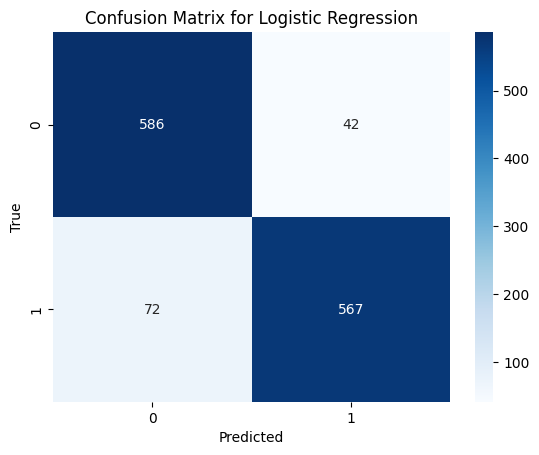

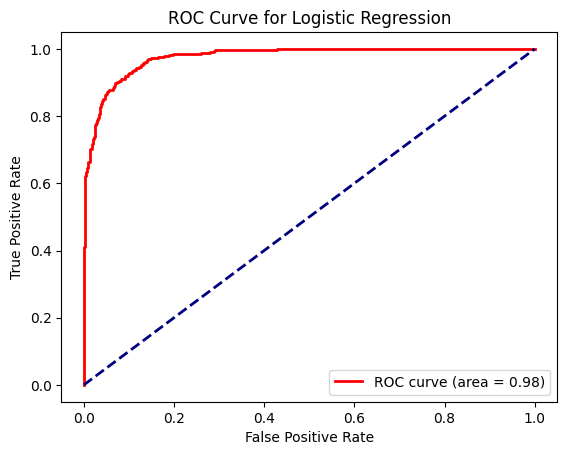

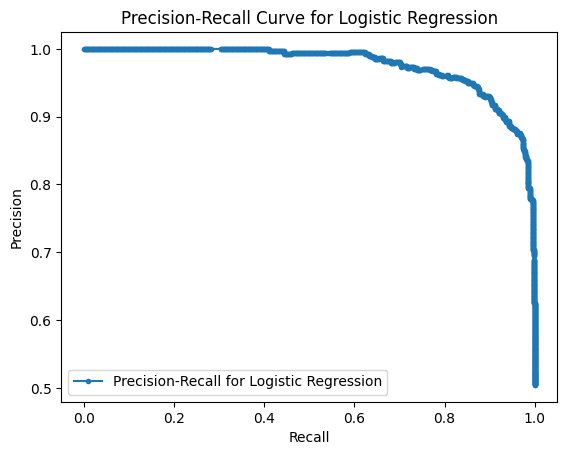

In [64]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tfidf)
y_pred_log_reg_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))

# Visualizations for Logistic Regression
plot_confusion_matrix(y_test, y_pred_log_reg, "Logistic Regression")
plot_roc_curve(y_test, y_pred_log_reg_proba, "Logistic Regression")
plot_precision_recall_curve(y_test, y_pred_log_reg_proba, "Logistic Regression")

Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83       628
           1       0.78      0.98      0.87       639

    accuracy                           0.85      1267
   macro avg       0.88      0.85      0.85      1267
weighted avg       0.88      0.85      0.85      1267

Accuracy: 0.8531965272296764


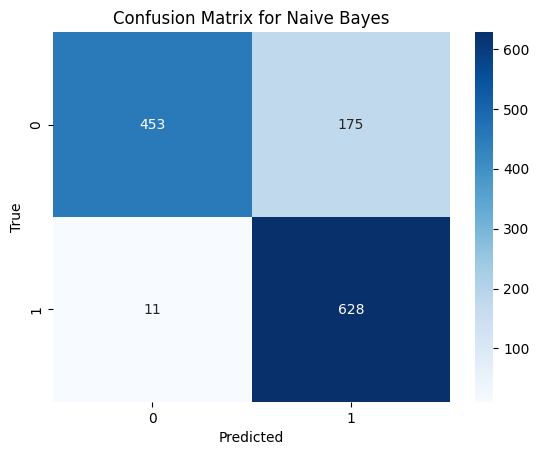

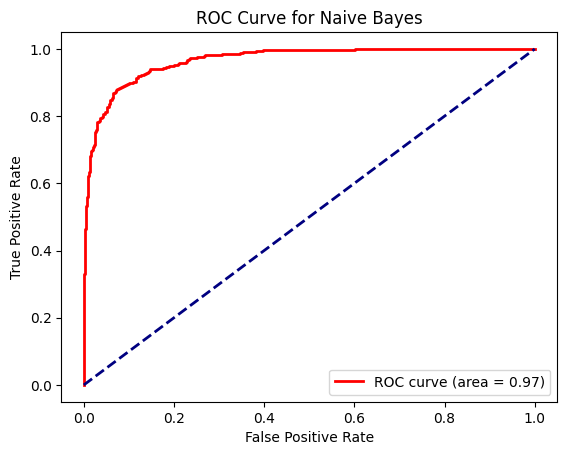

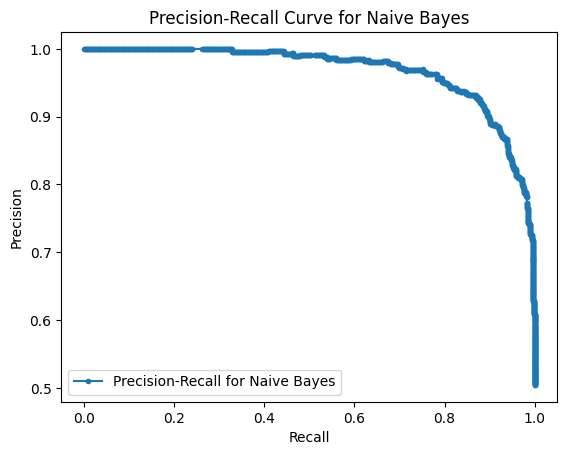

In [65]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_pred_nb_proba = nb.predict_proba(X_test_tfidf)[:, 1]

print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# Visualizations for Naive Bayes
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_roc_curve(y_test, y_pred_nb_proba, "Naive Bayes")
plot_precision_recall_curve(y_test, y_pred_nb_proba, "Naive Bayes")

Random Forest Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       628
           1       0.90      0.91      0.90       639

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267

Accuracy: 0.9005524861878453


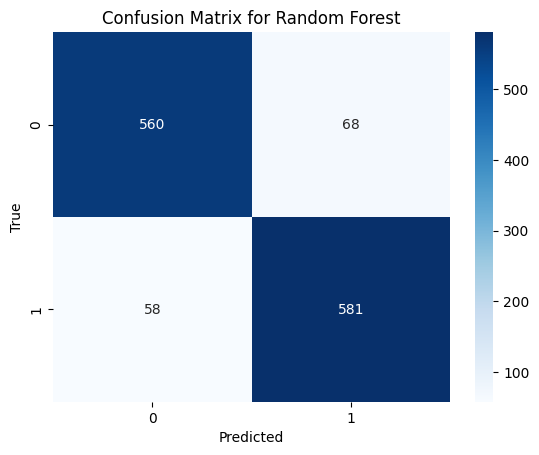

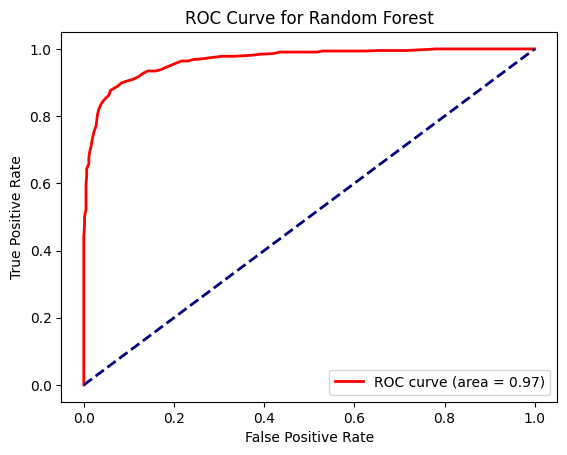

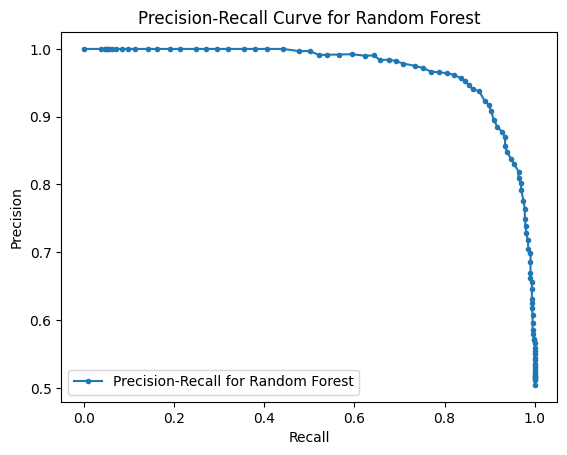

In [66]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
y_pred_rf_proba = rf.predict_proba(X_test_tfidf)[:, 1]

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Visualizations for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_roc_curve(y_test, y_pred_rf_proba, "Random Forest")
plot_precision_recall_curve(y_test, y_pred_rf_proba, "Random Forest")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
254/254 [==============================] - 87s 312ms/step - loss: 0.6632 - accuracy: 0.6196 - val_loss: 0.6136 - val_accuracy: 0.6913
Epoch 2/3
254/254 [==============================] - 76s 298ms/step - loss: 0.5209 - accuracy: 0.7748 - val_loss: 0.4706 - val_accuracy: 0.7909
Epoch 3/3
40/40 [==============================] - 5s 125ms/step - loss: 0.3379 - accuracy: 0.8713
BERT-tiny Accuracy: 0.8713496327400208
40/40 [==============================] - 6s 120ms/step


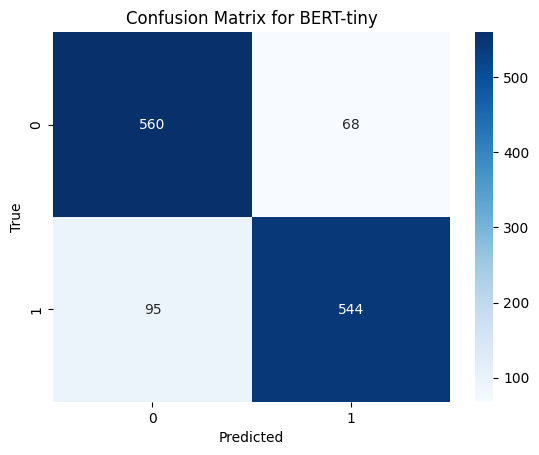

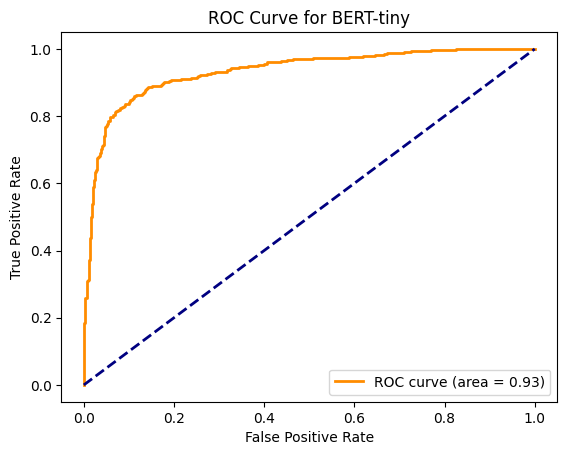

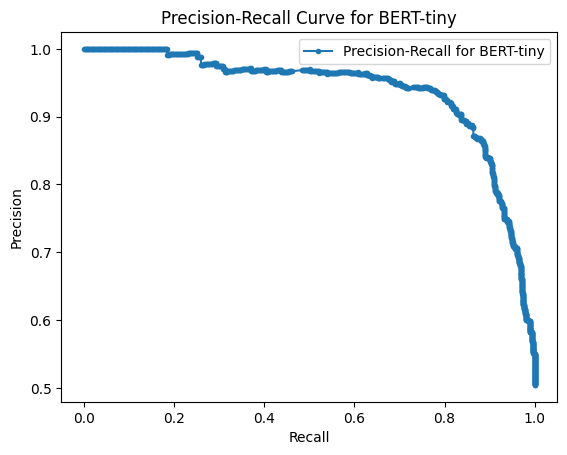

BERT-tiny Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       628
           1       0.89      0.85      0.87       639

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.87      1267
weighted avg       0.87      0.87      0.87      1267



In [67]:
# BERT-tiny preprocessing
def preprocess_for_bert(text):
    return ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]

# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

X_train_bert = tokenizer(
    list(X_train),
    padding=True,
    truncation=True,
    return_tensors="tf",
    max_length=128
)
X_test_bert = tokenizer(
    list(X_test),
    padding=True,
    truncation=True,
    return_tensors="tf",
    max_length=128
)

# Convert labels to integer type (if they are not already integers)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Load the BERT-tiny model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=2)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_bert['input_ids'],
    y_train,
    epochs=3,
    batch_size=16,
    validation_split=0.2
)

# Evaluate on test data
bert_eval = model.evaluate(X_test_bert['input_ids'], y_test)
print(f"BERT-tiny Accuracy: {bert_eval[1]}")

# Predictions using BERT-tiny
bert_predictions = model.predict(X_test_bert['input_ids']).logits
bert_pred_proba = tf.nn.softmax(bert_predictions, axis=1)[:, 1]
bert_predictions = np.argmax(bert_predictions, axis=1)

# Function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function for plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Function for plotting Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'Precision-Recall for {model_name}')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Visualizations for BERT-tiny
plot_confusion_matrix(y_test, bert_predictions, "BERT-tiny")
plot_roc_curve(y_test, bert_pred_proba, "BERT-tiny")
plot_precision_recall_curve(y_test, bert_pred_proba, "BERT-tiny")

# Print classification report
print("BERT-tiny Report:\n", classification_report(y_test, bert_predictions))
